# Credit Risk Analysis - Statistical Inference

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import duckdb as db



Initializing connection to the database and loading the data.

In [32]:
con = db.connect(database='home_credit.db')

Retrieve prepared dataset.

In [33]:
prep_app_merged_history_df = con.execute("SELECT * FROM prep_app_merged_history").fetch_df()

Remove feature that mistakenly remained in the dataset.

In [36]:
prep_app_merged_history_df.drop(columns = 'NAME_CONTRACT_STATUS', inplace = True)

As we have around 300 features, a correlation heatmap would be too crowded. We will only show the correlation of the target variable with the other features.

Getting the correlation coefficient between the predictors and the target variable.

In [37]:
corr_matrix = prep_app_merged_history_df.corr()
target_corr = corr_matrix['TARGET'].sort_values(ascending=False)
print(f"Features most correlated with the target:\n{target_corr}")


Features most correlated with the target:
TARGET                                    1.000000
prev_card_avg_utilization                 0.135560
prev_card_recent_dpd                      0.113863
prev_card_max_utilization                 0.097011
prev_card_avg_balance_last_3m             0.089146
                                            ...   
prev_card_max_principal_reduction_rate   -0.067930
bureau_pct_Closed                        -0.079369
bureau_proportion_left                   -0.093223
EXT_SOURCE_3                             -0.155892
EXT_SOURCE_2                             -0.160295
Name: TARGET, Length: 309, dtype: float64


Retrieving the top 5 based on absolute value.

In [38]:
top_5_features = target_corr.abs().sort_values(ascending=False).head(6)
print(top_5_features)

TARGET                       1.000000
EXT_SOURCE_2                 0.160295
EXT_SOURCE_3                 0.155892
prev_card_avg_utilization    0.135560
prev_card_recent_dpd         0.113863
prev_card_max_utilization    0.097011
Name: TARGET, dtype: float64


We have to note that the correlation coefficients are very low, so I will do statistical tests to check their significance.

Two of them are features from the application data without further explanation.

Three of them are features from the previous application data, where utilization was engineered from the given features and dpd was aggregated to the form we use it in.

## Chi-square test for boolean features

Chi-square determines if there is a significant association between two categorical variables. 

The null hypothesis is that the two variables are independent.
The alternative hypothesis is that the two variables are dependent.

I set the significance level to 0.05, which is a common threshold in hypothesis testing.

In [39]:
from scipy.stats import chi2_contingency

boolean_features = ['EXT_SOURCE_2', 'EXT_SOURCE_3']

for feature in boolean_features:
    contingency_table = pd.crosstab(prep_app_merged_history_df[feature], columns=prep_app_merged_history_df['TARGET']) 
    
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    if p_value < 0.05:
        print(f"Significant association between '{feature}' and target. p-value: {p_value:.4f}")
    else:
        print(f"No significant association between '{feature}' and target. p-value: {p_value:.4f}")

Significant association between 'EXT_SOURCE_2' and target. p-value: 0.0000
Significant association between 'EXT_SOURCE_3' and target. p-value: 0.0000


Text(0.5, 1.0, 'Barplot of EXT_SOURCE_2 vs TARGET')

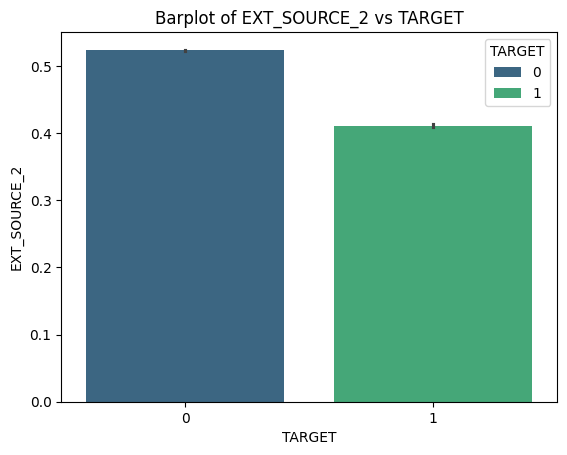

In [50]:
sns.barplot(x='TARGET', y='EXT_SOURCE_2', data=prep_app_merged_history_df, hue='TARGET', palette='viridis')
plt.title('Barplot of EXT_SOURCE_2 vs TARGET')

Text(0.5, 1.0, 'Barplot of EXT_SOURCE_3 vs TARGET')

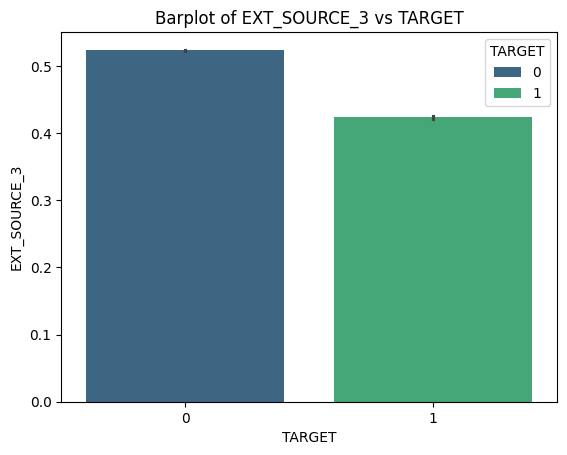

In [51]:
sns.barplot(x='TARGET', y='EXT_SOURCE_3', data=prep_app_merged_history_df, hue='TARGET', palette='viridis')
plt.title('Barplot of EXT_SOURCE_3 vs TARGET')

In [40]:
from scipy.stats import mannwhitneyu
import numpy as np

cleaned = prep_app_merged_history_df.dropna(subset=['prev_card_avg_utilization', 'prev_card_recent_dpd', 'prev_card_max_utilization'])

numerical_features = ['prev_card_avg_utilization', 'prev_card_recent_dpd', 'prev_card_max_utilization']

for feature in numerical_features:
    group1 = cleaned[cleaned['TARGET'] == 0][feature]
    group2 = cleaned[cleaned['TARGET'] == 1][feature]
    
    stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    
    print(f"Mann-Whitney U test for '{feature}': p-value = {np.format_float_scientific(p_value, precision=4)}")


Mann-Whitney U test for 'prev_card_avg_utilization': p-value = 4.5931e-28
Mann-Whitney U test for 'prev_card_recent_dpd': p-value = 1.2703e-35
Mann-Whitney U test for 'prev_card_max_utilization': p-value = 1.6865e-09


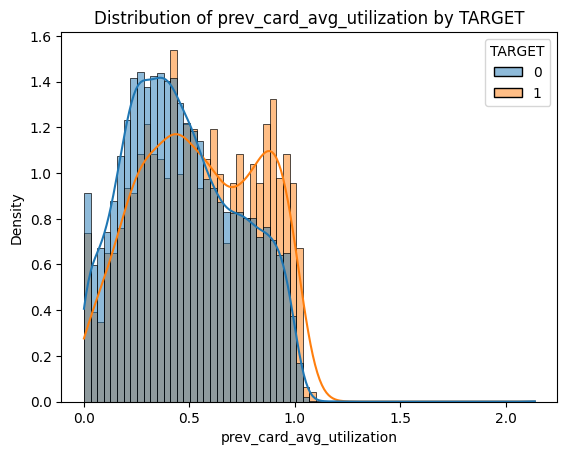

In [57]:
sns.histplot(data=cleaned, x='prev_card_avg_utilization', hue='TARGET', kde=True, stat="density", common_norm=False)
plt.title('Distribution of prev_card_avg_utilization by TARGET')
plt.show()

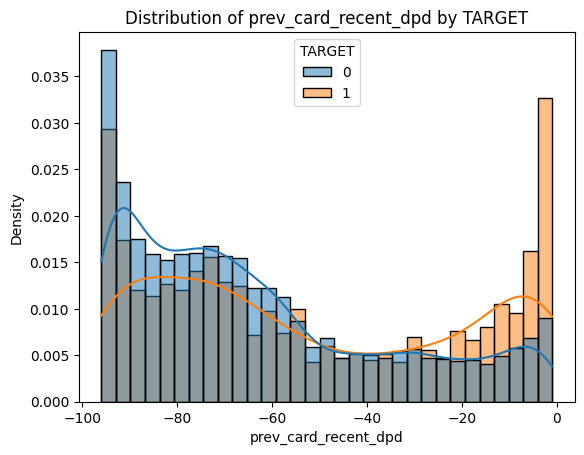

In [56]:
sns.histplot(data=cleaned, x='prev_card_recent_dpd', hue='TARGET', kde=True, stat="density", common_norm=False)
plt.title('Distribution of prev_card_recent_dpd by TARGET')
plt.show()

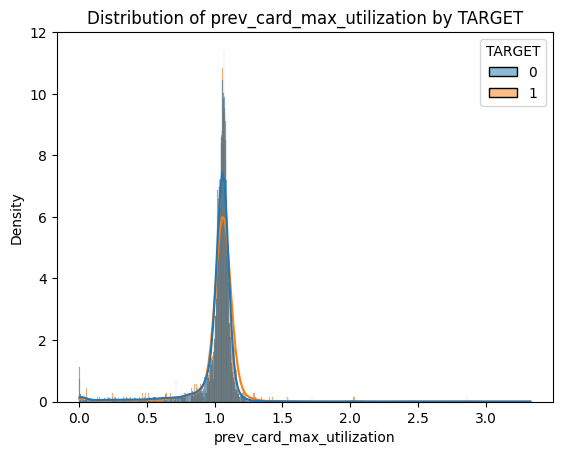

In [55]:
sns.histplot(data=cleaned, x='prev_card_max_utilization', hue='TARGET', kde=True, stat="density", common_norm=False)
plt.title('Distribution of prev_card_max_utilization by TARGET')
plt.show()

## Conclusion

Even though the correlation coefficients are low, the chi-square and Mann-Whitney test shows that there is a significant association between the target variable and the features chosen earlier.

In [58]:
con.close()